In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical


import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

# Generators

In [0]:
def image_generator(files, batch_size = 16, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))

        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)

    batch_y = to_categorical(batch_y)
    # (20, 256, 256, 1) --> (20, 256, 256, 2)

    yield (batch_x, batch_y)      
    

In [0]:
batch_size = 16 

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

In [32]:
print (x.shape, y.shape)

(16, 256, 256, 3) (16, 256, 256, 2)


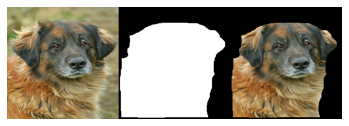

In [33]:
plt.axis('off')
img = x[0]
# img (256, 256, 3)
msk = y[0]
# mask (256, 256, 2)

msk = msk[:,:,1]
# msk[:,:,0] --> 배경이 1, 물체가 0
# msk[:,:,1] --> 배경이 0, 물체가 1
# msk (256, 256, 2) -> (256, 256)

msk = np.stack((msk,)*3, axis=-1)
plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [0]:
def block_residual(x, nKernels):
  identity = x
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  
  return x + identity


# Model

In [0]:
from tensorflow.keras.layers import concatenate


def mnet(sz = (256, 256, 3)):
  nkernel = 16
  x = Input(sz)
  input_feature = Conv2D(16, (1,1), activation='relu')(x)

  L_Leg_1 = MaxPooling2D((2,2)) (input_feature)
  L_Leg_2 = MaxPooling2D((2,2)) (L_Leg_1)
  L_Leg_3 = MaxPooling2D((2,2)) (L_Leg_2)
  L_Leg_4 = MaxPooling2D((2,2)) (L_Leg_3)

  # layer 1, size = (256, 256, 16)
  layer_1_1 = Conv2D(nkernel, (3, 3), activation='relu', padding='same')(input_feature)
  layer_1_1 = BatchNormalization()(layer_1_1)
  print(layer_1_1.shape)
  print(input_feature.shape)
  layer_1_c = concatenate([layer_1_1, input_feature])
  layer_1_2 = Conv2D(nkernel*2, (3, 3), activation='relu', padding='same')(layer_1_c)
  layer_1_2 = BatchNormalization()(layer_1_2)
  layer_1_p = MaxPooling2D((2, 2)) (layer_1_2)

  # layer 2
  layer_2_1 = concatenate([L_Leg_1, layer_1_p])
  layer_2_2 = Conv2D(nkernel*2, (3, 3), activation='relu', padding='same') (layer_2_1)
  layer_2_2 = BatchNormalization()(layer_2_2)
  layer_2_c = concatenate([layer_2_2, layer_1_p])

  layer_2_3 = Conv2D(nkernel*3, (3, 3), activation='relu', padding='same')(layer_2_c)
  layer_2_3 = BatchNormalization()(layer_2_3)
  layer_2_p = MaxPooling2D((2, 2)) (layer_2_3)

  # layer 3
  layer_3_1 = concatenate([L_Leg_2, layer_2_p])
  layer_3_2 = Conv2D(nkernel*3, (3, 3), activation='relu', padding='same') (layer_3_1)
  layer_3_2 = BatchNormalization()(layer_3_2)
  layer_3_c = concatenate([layer_3_2, layer_2_p])

  layer_3_3 = Conv2D(nkernel*4, (3, 3), activation='relu', padding='same') (layer_3_c)
  layer_3_3 = BatchNormalization()(layer_3_3)
  layer_3_p = MaxPooling2D((2, 2)) (layer_3_3)

  # layer 4
  layer_4_1 = concatenate([L_Leg_3, layer_3_p])
  layer_4_2 = Conv2D(nkernel*4, (3, 3), activation='relu', padding='same') (layer_4_1)
  layer_4_2 = BatchNormalization()(layer_4_2)
  layer_4_c = concatenate([layer_4_2, layer_3_p])

  layer_4_3 = Conv2D(nkernel*6, (3 ,3), activation='relu', padding='same')(layer_4_c)
  layer_4_3 = BatchNormalization()(layer_4_3)
  layer_4_p = MaxPooling2D((2, 2)) (layer_4_3)

  # layer 5
  layer_5_1 = concatenate([L_Leg_4, layer_4_p])
  layer_5_2 = Conv2D(nkernel*6, (3, 3), activation='relu', padding='same') (layer_5_1)
  layer_5_2 = BatchNormalization()(layer_5_2)

  layer_5_3 = Conv2D(nkernel*8, (3, 3), activation='relu', padding='same') (layer_5_2)
  layer_5_3 = BatchNormalization()(layer_5_3)

  layer_5_4 = Conv2D(nkernel*6, (3, 3), activation='relu', padding='same') (layer_5_3)
  layer_5_4 = BatchNormalization()(layer_5_4)

  # layer 6
  layer_6_u = UpSampling2D((2, 2)) (layer_5_4)
  layer_6_1 = concatenate([layer_6_u, layer_4_3])
  layer_6_2 = Conv2D(nkernel*6, (3, 3), activation='relu', padding='same') (layer_6_1)
  layer_6_2 = BatchNormalization()(layer_6_2)

  layer_6_c = concatenate([layer_6_2, layer_6_u])
  layer_6_3 = Conv2D(nkernel*4, (3, 3), activation='relu', padding='same') (layer_6_c)
  layer_6_3 = BatchNormalization()(layer_6_3)

  # layer 7
  layer_7_u = UpSampling2D((2, 2)) (layer_6_3)
  layer_7_1 = concatenate([layer_7_u, layer_3_3])
  layer_7_2 = Conv2D(nkernel*4, (3, 3), activation='relu', padding='same') (layer_7_1)
  layer_7_2 = BatchNormalization()(layer_7_2)

  layer_7_c = concatenate([layer_7_2, layer_7_u])
  layer_7_3 = Conv2D(nkernel*3, (3, 3), activation='relu', padding='same') (layer_7_c)
  layer_7_3 = BatchNormalization()(layer_7_3)

  # layer 8
  layer_8_u = UpSampling2D((2, 2)) (layer_7_3)
  layer_8_1 = concatenate([layer_8_u, layer_2_3])
  layer_8_2 = Conv2D(nkernel*2, (3, 3), activation='relu', padding='same') (layer_8_1)
  layer_8_2 = BatchNormalization()(layer_8_2)

  layer_8_c = concatenate([layer_8_2, layer_8_u])
  layer_8_3 = Conv2D(nkernel*2, (3, 3), activation='relu', padding='same') (layer_8_c)
  layer_8_3 = BatchNormalization()(layer_8_3)

  # layer 9
  layer_9_u = UpSampling2D((2, 2)) (layer_8_3)
  layer_9_1 = concatenate([layer_9_u, layer_1_2])
  layer_9_2 = Conv2D(nkernel, (3, 3), activation='relu', padding='same') (layer_9_1)
  layer_9_2 = BatchNormalization()(layer_9_2)

  layer_9_c = concatenate([layer_9_2, layer_9_u])
  layer_9_3 = Conv2D(nkernel, (3, 3), activation='relu', padding='same') (layer_9_c)
  layer_9_3 = BatchNormalization()(layer_9_3)

  # R_Leg
  R_leg_1 = UpSampling2D((16, 16)) (layer_5_4)
  R_leg_2 = UpSampling2D((8, 8)) (layer_4_3)
  R_leg_3 = UpSampling2D((4, 4)) (layer_3_3)
  R_leg_4 = UpSampling2D((2, 2)) (layer_2_3)

  final_layer = concatenate([layer_9_3, R_leg_1, R_leg_2, R_leg_3, R_leg_4])
  outputs = Conv2D(2, 1, activation='softmax') (final_layer)
  
  #model creation 
  model = Model(inputs=[x], outputs=[outputs])
  # model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')
  model.compile(optimizer = 'rmsprop', loss = bce_dice_loss, metrics = [dice_coef])

  return model

In [37]:
model = mnet()

(?, 256, 256, 16)
(?, 256, 256, 16)


In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),
        'mean_dsc=',logs.get('dice_coef'),'val_mean_dsc=',logs.get('val_dice_coef'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        # input --> (1, 256,256, 3)
        # shape of pred --> (1, 256, 256, 2)
        
        msk = np.argmax(pred, axis=-1)
        # (1, 256, 256, 2) -> (1, 256, 256)
        msk  = msk.squeeze()
        # (1, 256, 256) --> (256, 256)
        msk = np.stack((msk,)*3, axis=-1)
        # (256, 256) --> (256, 256, 3)
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [39]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print (train_steps, test_steps)

438 23


i= 1 loss= 0.786415849986686 val_loss= 0.9574249879173611 mean_dsc= 0.64846474 val_mean_dsc= 0.6761399


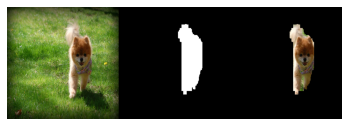

i= 2 loss= 0.47683085514802365 val_loss= 0.5263204794862996 mean_dsc= 0.7979438 val_mean_dsc= 0.7921064


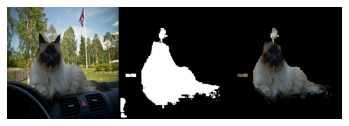

i= 3 loss= 0.3841241803275396 val_loss= 0.4665615092153135 mean_dsc= 0.8408888 val_mean_dsc= 0.79391974


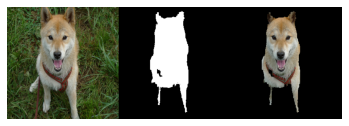

i= 4 loss= 0.3389565568060091 val_loss= 0.46298394190228503 mean_dsc= 0.8603635 val_mean_dsc= 0.8060617


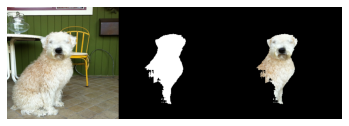

i= 5 loss= 0.3017569447284964 val_loss= 0.4399927699047586 mean_dsc= 0.87630314 val_mean_dsc= 0.828382


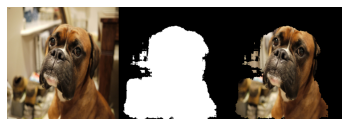

i= 6 loss= 0.27404878203455174 val_loss= 0.6287642147230066 mean_dsc= 0.88838774 val_mean_dsc= 0.7549733


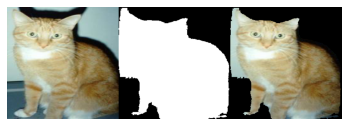

i= 7 loss= 0.2604114076114136 val_loss= 0.36171921698943427 mean_dsc= 0.89381486 val_mean_dsc= 0.8598069


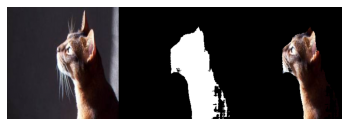

i= 8 loss= 0.240939752151977 val_loss= 0.3379579387281252 mean_dsc= 0.902282 val_mean_dsc= 0.8731055


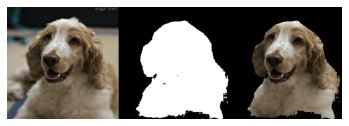

i= 9 loss= 0.2253403646624796 val_loss= 0.3808359600927519 mean_dsc= 0.9088202 val_mean_dsc= 0.85613966


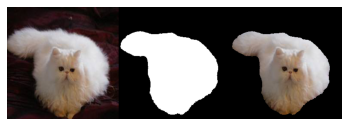

i= 10 loss= 0.21358491351071013 val_loss= 0.3395442995040313 mean_dsc= 0.913523 val_mean_dsc= 0.85806185


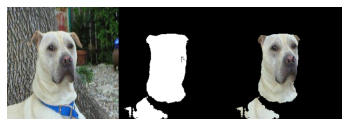

i= 11 loss= 0.20195476084811503 val_loss= 0.33874404236026434 mean_dsc= 0.918239 val_mean_dsc= 0.8737


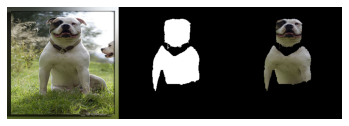

i= 12 loss= 0.1891083474606956 val_loss= 0.350145534976669 mean_dsc= 0.9233926 val_mean_dsc= 0.87274545


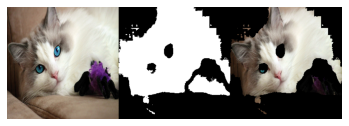

i= 13 loss= 0.1804717066591461 val_loss= 0.2614344792521518 mean_dsc= 0.9275772 val_mean_dsc= 0.89300925


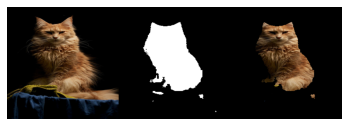

i= 14 loss= 0.17339061540827905 val_loss= 0.2952044230440389 mean_dsc= 0.93007034 val_mean_dsc= 0.8869506


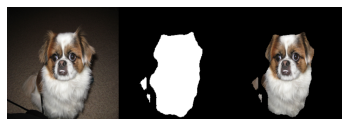

i= 15 loss= 0.16564867269570968 val_loss= 0.3379168873247893 mean_dsc= 0.93297094 val_mean_dsc= 0.86443377


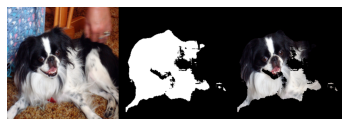

i= 16 loss= 0.16024761948071115 val_loss= 0.2939127171817033 mean_dsc= 0.9351593 val_mean_dsc= 0.8921523


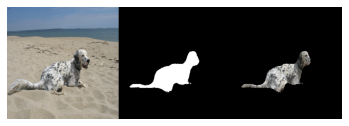

i= 17 loss= 0.15447955787794232 val_loss= 0.33803405515525653 mean_dsc= 0.9374979 val_mean_dsc= 0.8681794


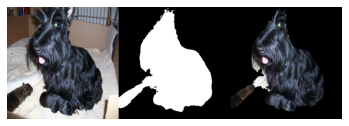

i= 18 loss= 0.14772294783224799 val_loss= 0.3126473737799603 mean_dsc= 0.93958235 val_mean_dsc= 0.88328296


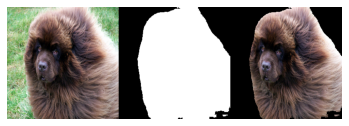

i= 19 loss= 0.1426165816990752 val_loss= 0.3460135272015696 mean_dsc= 0.9417113 val_mean_dsc= 0.8773638


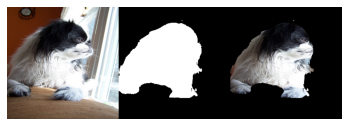

i= 20 loss= 0.13587921253962604 val_loss= 0.2716350795134254 mean_dsc= 0.94422305 val_mean_dsc= 0.9047054


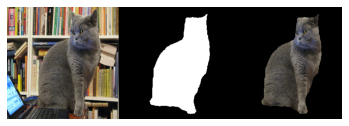

In [40]:
model.fit_generator(train_generator, 
                    epochs = 20, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [0]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-05-08 11:38:18--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 99.86.38.68, 99.86.38.73, 99.86.38.15, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|99.86.38.68|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.01s   

2020-05-08 11:38:18 (6.12 MB/s) - ‘test.jpg’ saved [63219/63219]



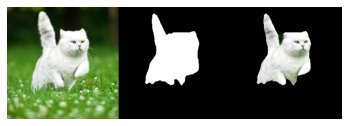

In [0]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
# msk  = pred.squeeze()
# msk = np.stack((msk,)*3, axis=-1)
# msk[msk >= 0.5] = 1 
# msk[msk < 0.5] = 0 

msk = np.argmax(pred, axis=-1)
# (1, 256, 256)
msk  = msk.squeeze()
# (256, 256)
msk = np.stack((msk,)*3, axis=-1)
# (256, 256, 3)

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

